In [11]:
from collections import deque
import numpy as np
import numpy.linalg as la

import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

import modern_robotics as mr

import networkx as nx

from description.kinematics import JointPoint

In [2]:
graph = nx.Graph()
# https://cad.onshape.com/documents/52eb11422c701d811548a6f5/w/655758bb668dff773a0e7c1a/e/77ff7f84e82d8fb31fe9c30b
# abs_ground = np.array([0.065, 0, -0.015])
abs_ground = np.array([0.065, 0, -0.047])
pos_toeA_joint = np.array([0.065, 0, -0.047]) - abs_ground
pos_toeA_tarus_joint = np.array([-0.273, 0, -0.350]) - abs_ground
pos_shin_joint = np.array([0.021, 0, -0.159]) - abs_ground
pos_knee_spring = np.array([0.011, 0, -0.219]) - abs_ground
pos_tarus_joint = np.array([-0.237, 0, -0.464]) - abs_ground
pos_foot_joint = np.array([-0.080, 0, -0.753]) - abs_ground
pos_molet_joint = np.array([-0.207, 0, -0.552]) - abs_ground
pos_toeB_joint = np.array([-0.257, 0, -0.579]) - abs_ground
pos_toeB_foot_joint = np.array([-0.118, 0, -0.776]) - abs_ground

ground_joint = JointPoint(r=np.zeros(3), w=np.array([0,1,0]), attach_ground=True, active=True)
shin_joint = JointPoint(r=pos_shin_joint, w=np.array([0,1,0]), active=True)
knee_spring = JointPoint(pos_knee_spring, w=np.array([0,1,0]), weld=True)
tarus_joint = JointPoint(r=pos_tarus_joint, w=np.array([0,1,0]))
foot_joint = JointPoint(r=pos_foot_joint, w=np.array([0,1,0]), attach_endeffector=True)

toeA_joint = JointPoint(r=pos_toeA_joint, w=np.array([0,1,0]))
connect_toeA_tarus_joint = JointPoint(r=pos_toeA_tarus_joint, w=np.array([0,1,0]), weld=True)

molet_joint = JointPoint(r=pos_molet_joint, w=np.array([0,1,0]), active=True)
toeB_joint = JointPoint(r=pos_toeB_joint, w=np.array([0,1,0]))
toeB_foot_joint = JointPoint(r=pos_toeB_foot_joint, w=np.array([0,1,0]), attach_endeffector=True)

joints = [ground_joint, shin_joint, knee_spring, tarus_joint, foot_joint, toeA_joint, connect_toeA_tarus_joint,
            molet_joint, toeB_joint, toeB_foot_joint]

for j in joints:
    graph.add_node(j)
main_branch = [ground_joint, shin_joint, knee_spring, tarus_joint, foot_joint]
add_branch_1 = [[ground_joint,shin_joint], toeA_joint, connect_toeA_tarus_joint, [tarus_joint,foot_joint]]
add_branch_2 = [[tarus_joint,foot_joint], molet_joint, toeB_joint, toeB_foot_joint, foot_joint]

In [3]:
def calc_weight(n0, n1):
    norm = la.norm(n0.r-n1.r)
    norm = norm if not np.isclose(norm, 0) else 1e5
    return 1/(norm)

In [4]:
for id in range(len(main_branch) - 1):
    graph.add_edge(
        main_branch[id],
        main_branch[id + 1],
        variable=False,
        active=False,
        weight=calc_weight(main_branch[id], main_branch[id + 1]),
    )
for id in range(len(add_branch_1) - 1):
    if isinstance(add_branch_1[id], list):
        for j in add_branch_1[id]:
            graph.add_edge(
                j,
                add_branch_1[id + 1],
                variable=False,
                active=False,
                weight=calc_weight(j, add_branch_1[id + 1]),
            )
    elif isinstance(add_branch_1[id + 1], list):
        for j in add_branch_1[id + 1]:
            graph.add_edge(
                j,
                add_branch_1[id],
                variable=False,
                active=False,
                weight=calc_weight(j, add_branch_1[id]),
            )
    else:
        graph.add_edge(
            add_branch_1[id],
            add_branch_1[id + 1],
            variable=False,
            active=False,
            weight=calc_weight(add_branch_1[id], add_branch_1[id + 1]),
        )
for id in range(len(add_branch_2) - 1):
    if isinstance(add_branch_2[id], list):
        for j in add_branch_2[id]:
            graph.add_edge(
                j,
                add_branch_2[id + 1],
                variable=False,
                active=False,
                weight=calc_weight(j, main_branch[id + 1]),
            )
    elif isinstance(add_branch_2[id + 1], list):
        for j in add_branch_2[id + 1]:
            graph.add_edge(
                j,
                add_branch_2[id],
                variable=False,
                active=False,
                weight=calc_weight(j, add_branch_2[id]),
            )
    else:
        graph.add_edge(
            add_branch_2[id],
            add_branch_2[id + 1],
            variable=False,
            active=False,
            weight=calc_weight(add_branch_2[id], add_branch_2[id + 1]),
        )

In [5]:
pos = {}
for node in graph:
    pos[node] = [node.r[0],node.r[2]]

In [6]:
Rad = 0.751618254168963
joint_nodes = set(graph.nodes())
ground_joints = set(sorted(filter(lambda n: n.attach_ground, joint_nodes), key= lambda x: la.norm(x.r)))
ee_joints = set(sorted(filter(lambda n: n.attach_endeffector, joint_nodes), key= lambda x: np.abs(la.norm(x.r) - Rad)))
ground_joints, ee_joints

({JointPoint(r=array([0., 0., 0.]), w=array([0, 1, 0]), weld=False, active=True, attach_ground=True, attach_endeffector=False, name='J1', instance_counter=0)},
 {JointPoint(r=array([-0.145,  0.   , -0.706]), w=array([0, 1, 0]), weld=False, active=False, attach_ground=False, attach_endeffector=True, name='J5', instance_counter=0),
  JointPoint(r=array([-0.183,  0.   , -0.729]), w=array([0, 1, 0]), weld=False, active=False, attach_ground=False, attach_endeffector=True, name='J10', instance_counter=0)})

делать это рекурсивно

In [12]:
def get_rot_matrix_by_vec(v):
    ez = np.array([0,0,1])
    ex = np.array([1,0,0])
    # axis = np.sign(np.inner(ex, v)) * mr.VecToso3(ez) @ v/ np.linalg.norm(mr.VecToso3(ez) @ v)
    axis = mr.VecToso3(ez) @ v/ np.linalg.norm(mr.VecToso3(ez) @ v)
    angle = np.arccos(np.inner(ez, v) / la.norm(ez) / la.norm(v))
    out = lambda q: R.from_rotvec(axis * (angle + np.sign(np.inner(ex, v)) * q), )
    print(axis, mr.VecToso3(ez) @ v/ np.linalg.norm(mr.VecToso3(ez) @ v), angle)
    return out 

In [13]:
ez = np.array([0,0,1])
ex = np.array([1,0,0])

v1z = main_branch[1].r - main_branch[0].r

In [14]:
R1 = get_rot_matrix_by_vec(v1z)

H_w_b1 = np.eye(4)
H_w_b1[:3,:3] = R1(0).as_matrix()

[ 0. -1.  0.] [ 0. -1.  0.] 2.767259037582209


In [15]:
R1(0).as_quat()

array([ 0.        , -0.98253537,  0.        ,  0.18607593])

In [16]:
v2z = main_branch[2].r - main_branch[1].r

v2z_l = la.inv(H_w_b1) @ np.array([*v2z.tolist(), 1])

R2 = get_rot_matrix_by_vec(v2z_l[:3])

H_b1_b2 = np.eye(4)
H_b1_b2[:3,:3] = R2(0).as_matrix()
H_b1_b2[:3,3] = np.array([0,0,la.norm(v1z)])

[ 0. -1.  0.] [ 0. -1.  0.] 0.20918493859295728


In [17]:
R2(0).as_quat()

array([ 0.        , -0.10440187,  0.        ,  0.99453519])

In [18]:
v3z = main_branch[3].r - main_branch[2].r

# v3z_l = R2(0).as_matrix().T @ R1(0).as_matrix().T @ v3z
v3z_l = la.inv(H_b1_b2) @ la.inv(H_w_b1) @ np.array([*v3z.tolist(), 0])


R3 = get_rot_matrix_by_vec(v3z_l[:3])

H_b2_b3 = np.eye(4)
H_b2_b3[:3,:3] = R3(0).as_matrix()
# H_b2_b3[:3,3] = v2z_l
H_b2_b3[:3,3] = np.array([0,0,la.norm(v2z)])

[0. 1. 0.] [0. 1. 0.] 0.6263346035715688


In [22]:
H_b2_b3

array([[ 0.81018152,  0.        ,  0.58617907,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [-0.58617907,  0.        ,  0.81018152,  0.06082763],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [15]:
v3z_l, v3z, la.inv(H_b2_b3) @ v2z_l

(array([0.20434794, 0.        , 0.28243746, 0.        ]),
 array([-0.248,  0.   , -0.245]),
 array([-0.00945663,  0.        , -0.00847871,  1.        ]))

In [16]:
q1 = 0
q2 = 0
q3 = 0

H_w_b1 = np.eye(4)
H_w_b1[:3,:3] = R1(q1).as_matrix()
# H_w_b1[:3,3] = np.array([0,0,la.norm(v1z)])

H_b1_b2 = np.eye(4)
H_b1_b2[:3,:3] = R2(q2).as_matrix()
H_b1_b2[:3,3] = np.array([0,0,la.norm(v1z)])
# H_b1_b2[:3,3] = np.array([0,0,la.norm(v2z)])
# H_b1_b2[:3,3] = v1z

H_b2_b3 = np.eye(4)
H_b2_b3[:3,:3] = R3(q3).as_matrix()
# H_b2_b3[:3,3] = v2z_l
H_b2_b3[:3,3] = np.array([0,0,la.norm(v2z)])
# H_b2_b3[:3,3] = np.array([0,0,0])

не сходится вращение и однородное преобразование

(-0.37349000000000004, 0.03549000000000001, -0.805545, 0.076545)

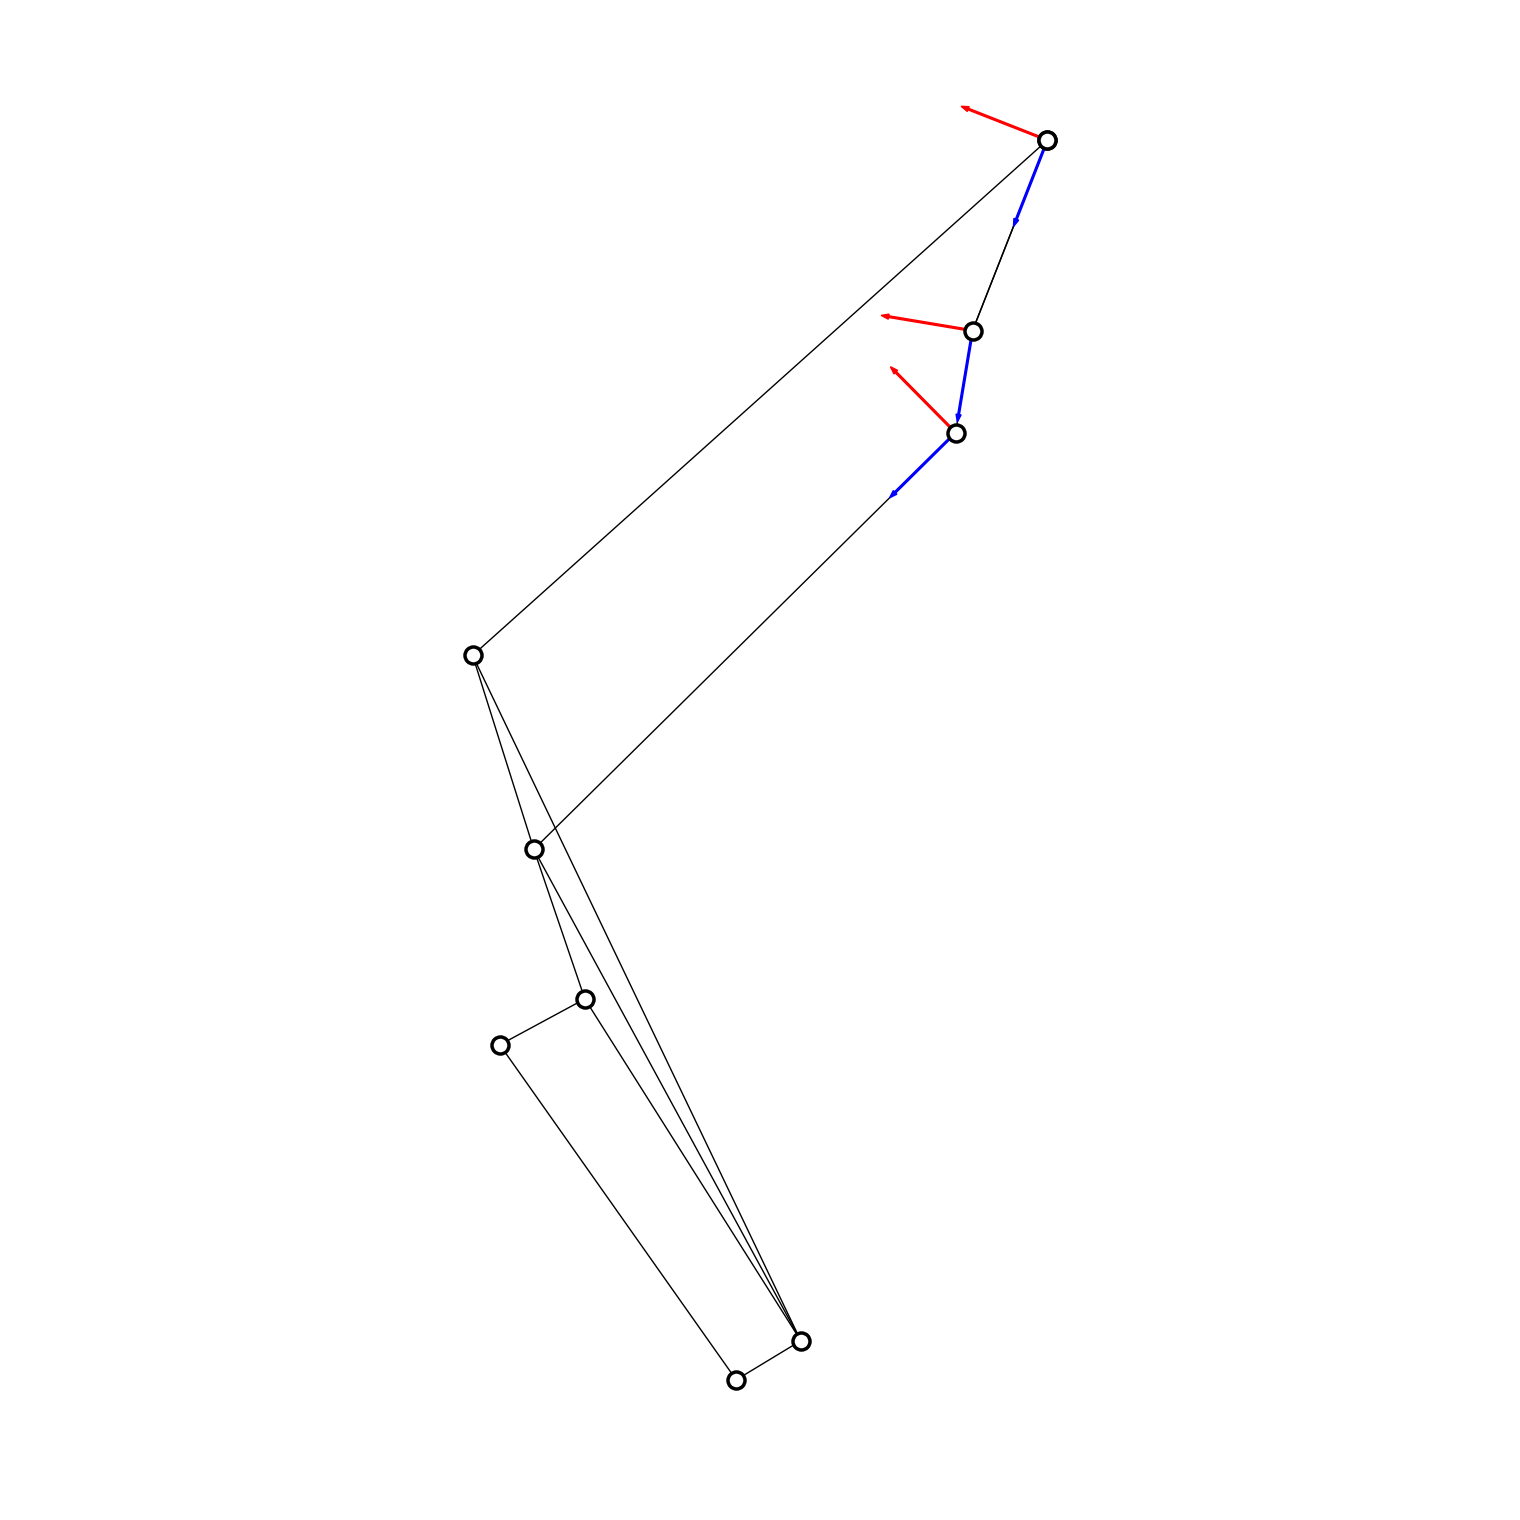

In [17]:
h_ex = np.array([ex[0],ex[1],ex[2],0])
h_ez = np.array([ez[0],ez[1],ez[2],0])

p0 = np.zeros(4)
p0[3] = 1


plt.figure(figsize=(15, 15))
nx.draw(graph, pos, node_color="w", linewidths=2.5, edgecolors="k", node_shape="o",node_size=150, with_labels=False)
v1x = H_w_b1 @ h_ex
e1z = H_w_b1 @ h_ez
p1 = H_w_b1 @ p0
plt.arrow(p1[0], p1[2],e1z[0]*0.05,e1z[2]*0.05, color="b")
plt.arrow(p1[0], p1[2],v1x[0]*0.05,v1x[2]*0.05, color="r")

e2z = H_w_b1 @ H_b1_b2 @ h_ez
v2x = H_w_b1 @ H_b1_b2 @ h_ex
p2 = H_w_b1 @ H_b1_b2 @ p0
plt.arrow(p2[0], p2[2],e2z[0]*0.05,e2z[2]*0.05, color="b")
plt.arrow(p2[0], p2[2],v2x[0]*0.05,v2x[2]*0.05, color="r")

e3z = H_w_b1 @ H_b1_b2 @ H_b2_b3 @ h_ez
v3x = H_w_b1 @ H_b1_b2 @ H_b2_b3 @ h_ex
p3 = H_w_b1 @ H_b1_b2 @ H_b2_b3 @ p0
plt.arrow(p3[0], p3[2],e3z[0]*0.05,e3z[2]*0.05, color="b")
plt.arrow(p3[0], p3[2],v3x[0]*0.05,v3x[2]*0.05, color="r")

plt.axis("equal")

(-0.37349000000000004, 0.03549000000000001, -0.805545, 0.076545)

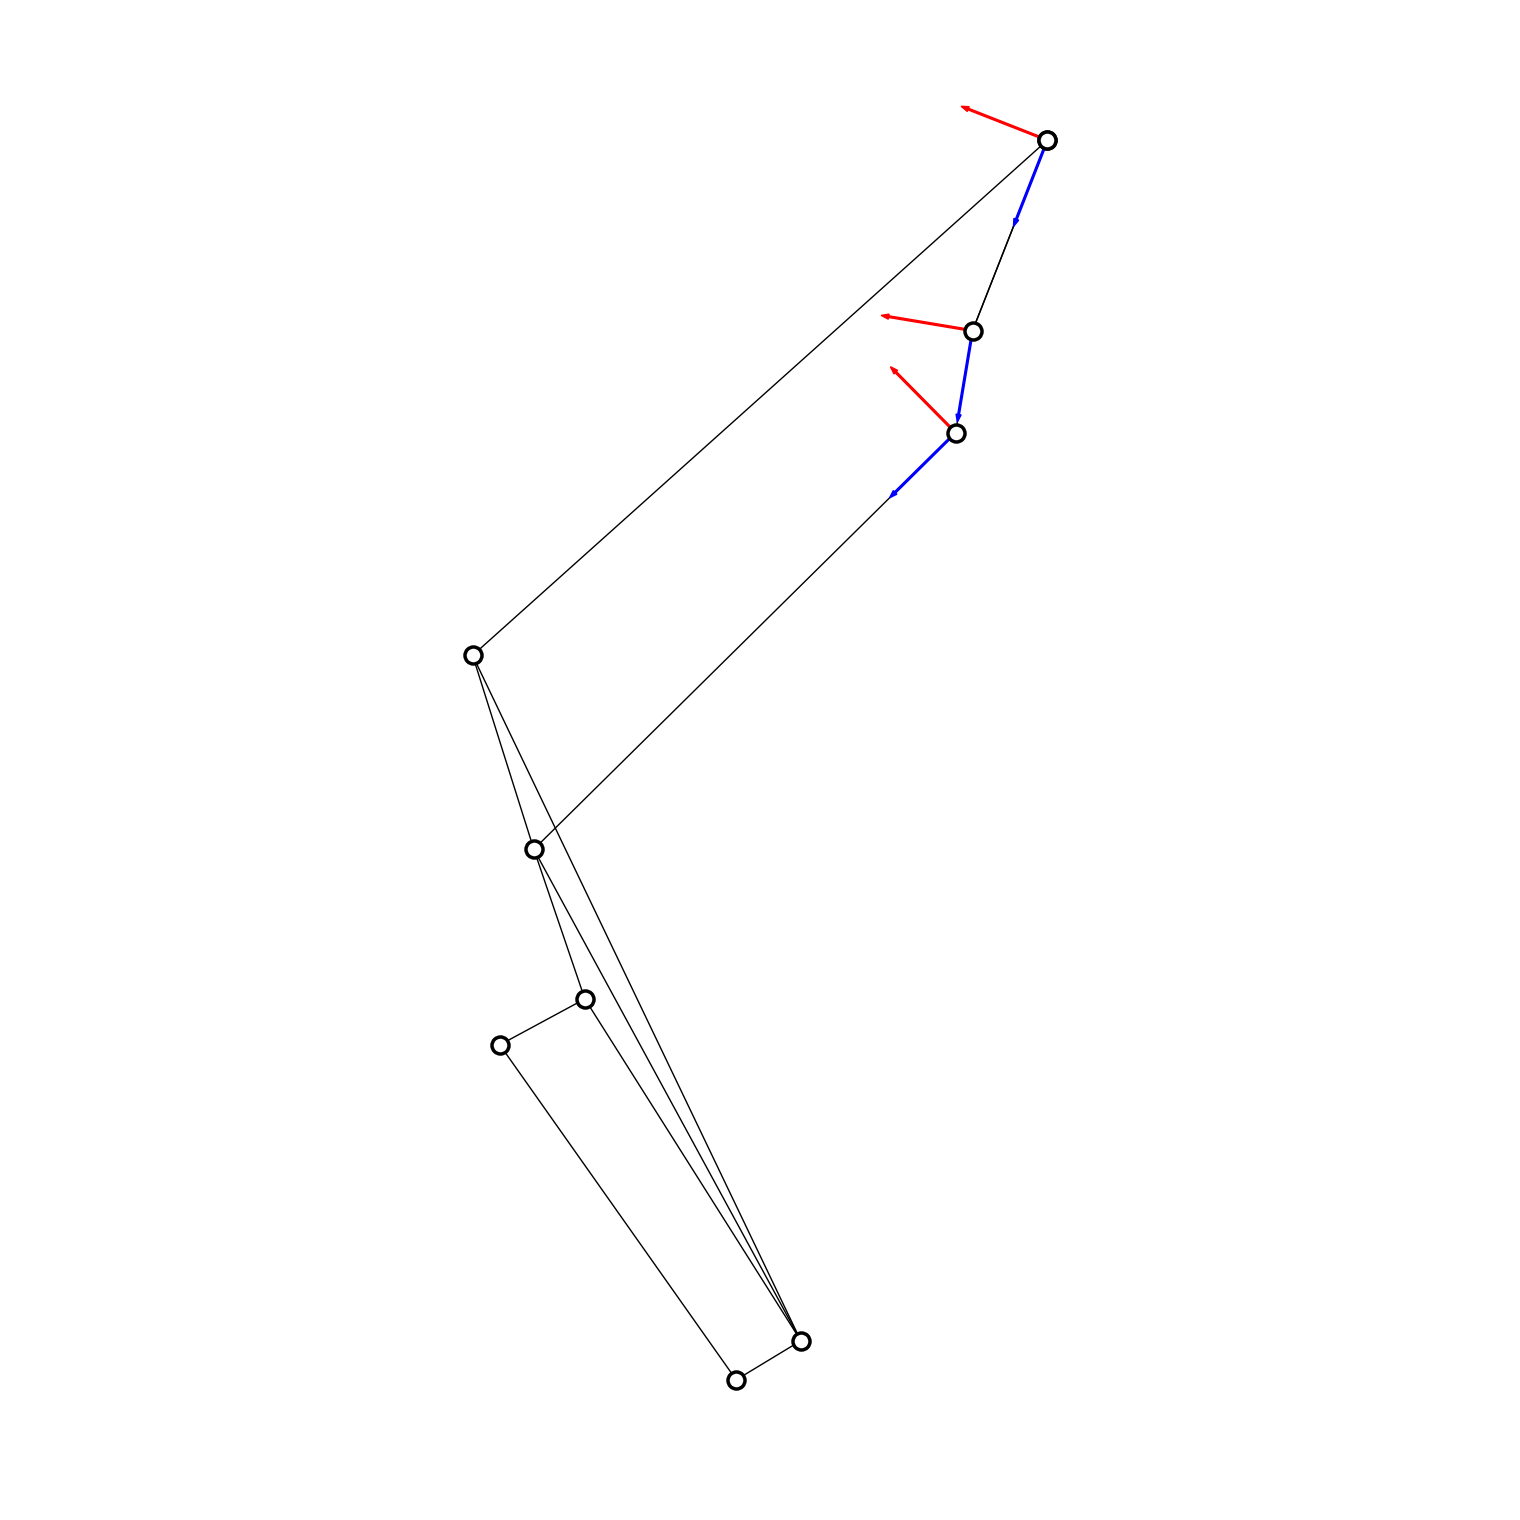

In [19]:


q1 = 0
q2 = 0
q3 = 0
plt.figure(figsize=(15, 15))
nx.draw(graph, pos, node_color="w", linewidths=2.5, edgecolors="k", node_shape="o",node_size=150, with_labels=False)
v1x = R1(q1).as_matrix() @ ex
e1z = R1(q1).as_matrix() @ ez
plt.arrow(main_branch[0].r[0],main_branch[0].r[2],e1z[0]*0.05,e1z[2]*0.05, color="b")
plt.arrow(main_branch[0].r[0],main_branch[0].r[2],v1x[0]*0.05,v1x[2]*0.05, color="r")

e2z = R1(q1).as_matrix() @ R2(q2).as_matrix() @ ez
v2x = R1(q1).as_matrix() @ R2(q2).as_matrix() @ ex
plt.arrow(main_branch[1].r[0],main_branch[1].r[2],e2z[0]*0.05,e2z[2]*0.05, color="b")
plt.arrow(main_branch[1].r[0],main_branch[1].r[2],v2x[0]*0.05,v2x[2]*0.05, color="r")

e3z = R1(q1).as_matrix() @ R2(q2).as_matrix() @ R3(q3).as_matrix() @ ez
v3x = R1(q1).as_matrix() @ R2(q2).as_matrix() @ R3(q3).as_matrix() @ ex
plt.arrow(main_branch[2].r[0],main_branch[2].r[2],e3z[0]*0.05,e3z[2]*0.05, color="b")
plt.arrow(main_branch[2].r[0],main_branch[2].r[2],v3x[0]*0.05,v3x[2]*0.05, color="r")

plt.axis("equal")

In [35]:
testR = R2(0.209).as_matrix()

test_th = np.arccos((np.trace(testR) - 1)/2)

test_omg = 1 / 2 / np.sin(test_th) * np.array([[testR[2,1]-testR[2,1]], [testR[0,2]-testR[2,0]], [testR[1,0]-testR[0,1]]])

np.pi/4, test_th, test_omg

(0.7853981633974483,
 0.0001849385921899674,
 array([[ 0.],
        [-1.],
        [ 0.]]))

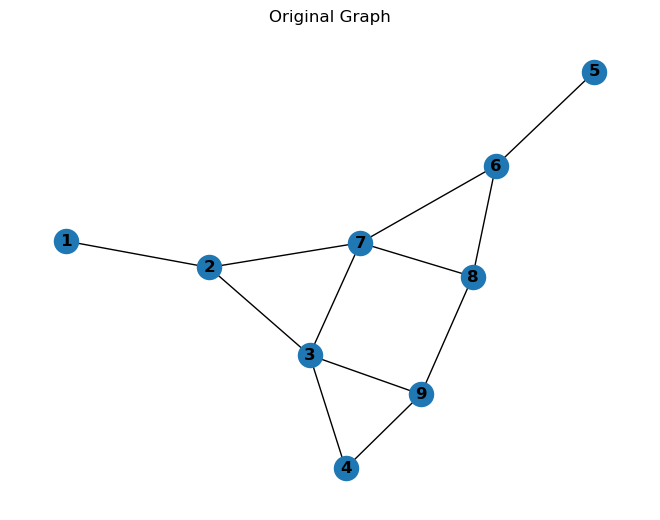

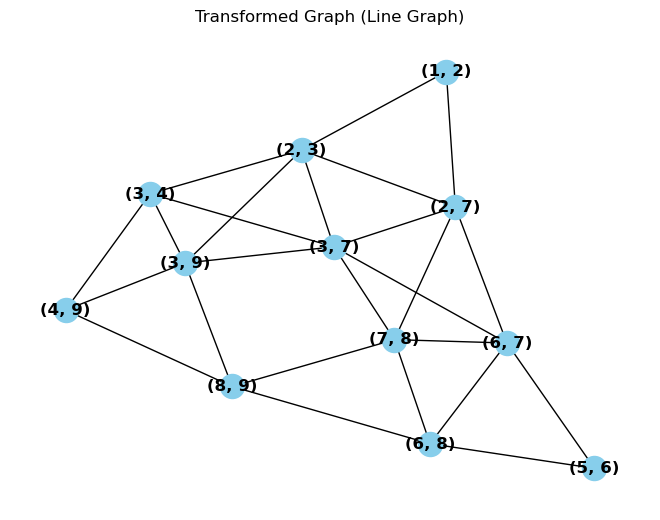

In [20]:
G = nx.Graph()#cassie_graph
# G.add_edges_from([(1, 2), (2, 3), (3, 1), (3, 4)])
G.add_edges_from([(1, 2), (2,3), (3, 4), (5,6), (6,7), (7,2), (7,3)])
G.add_edges_from([(6,8),(7,8),(8,9),(9,3),(9,4)])

# Visualize the original graph
nx.draw(G, with_labels=True, font_weight='bold')
plt.title('Original Graph')
plt.show()

# Convert nodes to edges and edges to nodes (Line Graph Transformation)
line_graph = nx.line_graph(G)

# Visualize the transformed graph
nx.draw(line_graph, with_labels=True, font_weight='bold', node_color='skyblue')
plt.title('Transformed Graph (Line Graph)')
plt.show()

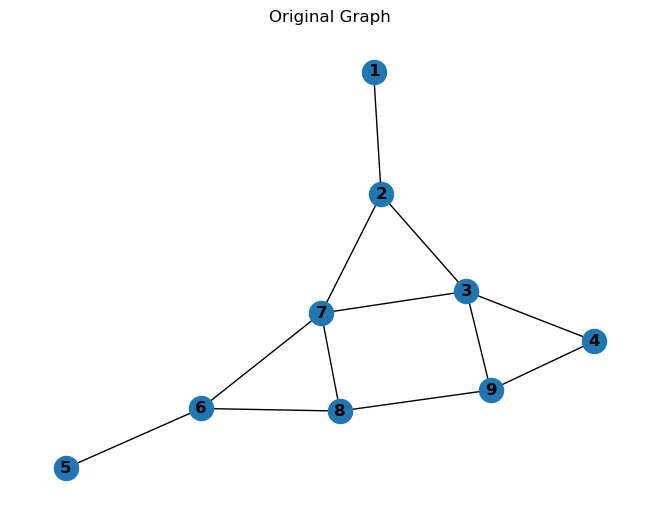

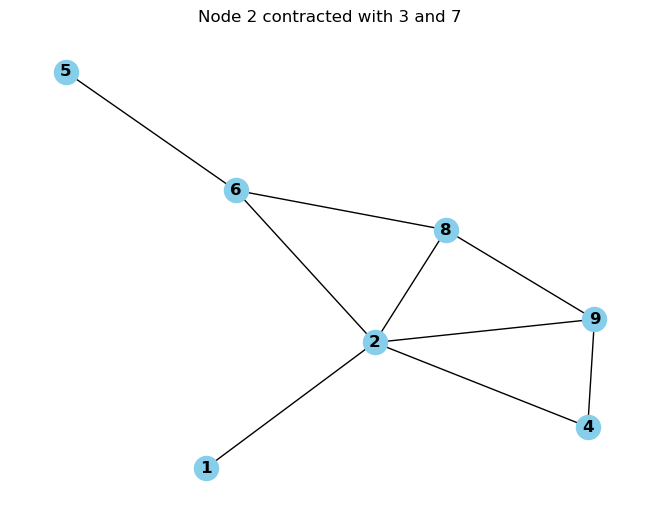

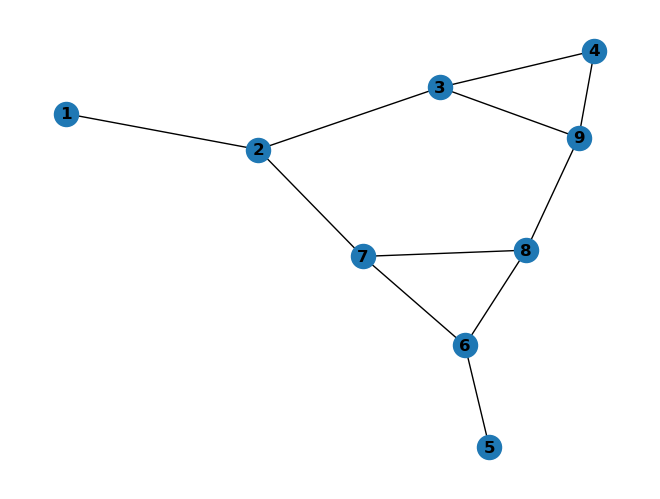

NetworkXError: nbunch is not a node or a sequence of nodes.

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

def custom_line_graph_transformation(graph):
    out_graph = nx.Graph()
    line_graph = graph.copy()
    counter = 0
    for node in graph.nodes():
        if node not in line_graph.nodes():
            continue
        neighbors = list(graph.neighbors(node))
        
        for i in range(len(neighbors)):
            for j in range(i + 1, len(neighbors)):
                if graph.has_edge(neighbors[i], neighbors[j]):
                    nx.contracted_nodes(line_graph, node, neighbors[i], self_loops=False, copy=False)
                    nx.contracted_nodes(line_graph, node, neighbors[j], self_loops=False, copy=False)
                    out_graph.add_node(f"L{counter}_3", g=False, joints=[node, neighbors[i], neighbors[j]])
                    # line_graph.remove_node(node)
                    nx.draw(line_graph, with_labels=True, font_weight='bold', node_color='skyblue')
                    plt.title(f"Node {node} contracted with {neighbors[i]} and {neighbors[j]}")
                    plt.show()
                    # graph.remove_edge(node, neighbors[i])
                    # graph.remove_edge(node, neighbors[j])
                    graph.remove_edge(neighbors[i], neighbors[j])
                    nx.draw(graph, with_labels=True, font_weight='bold')
                    plt.show()
    out_graph.add_node("G", joints=[])
    for node in graph.nodes():
        if graph.nodes[node].get("g"):
            out_graph.nodes["G"]["joints"].append(node)
    for edge in graph.edges():
        out_graph.add_node(f"L{counter}", g=False, joints=[edge[0], edge[1]])
        counter += 1
    for node1 in out_graph.nodes():
        joints = out_graph.nodes[node1]["joints"]
        for j in joints:
            if graph.nodes[j].get("g"):
                out_graph.add_edge(node1, "G", weight=j)
        for node2 in out_graph.nodes():
            if node1 == node2 and not (node1 != "G" and node2 != "G"):
                continue
            # print(out_graph.nodes[node1], out_graph.nodes[node2])
            intersection = set(out_graph.nodes[node1]["joints"]) & set(out_graph.nodes[node2]["joints"])
            # print(f"node1: {node1}, node2: {node2}, intersection: {intersection}")
            if len(intersection) == 1:
                out_graph.add_edge(node1, node2, weight=intersection.pop())
        if node == "G":
            continue
    return out_graph

# Create an example graph
G1 = G.copy()
G1.nodes[1]["g"] = True
G1.nodes[5]["g"] = True
# G.add_edges_from([(1, 2), (2, 3), (3, 1), (3, 4)])

# Visualize the original graph
nx.draw(G1, with_labels=True, font_weight='bold')
plt.title('Original Graph')
plt.show()

# Perform Custom Line Graph Transformation
newG = custom_line_graph_transformation(G1)

# Visualize the transformed graph
pos = nx.spring_layout(newG)
nx.draw_networkx_nodes(newG, pos)
nx.draw_networkx_edges(newG, pos)
nx.draw_networkx_labels(newG, pos)
nx.draw_networkx_edge_labels(
    newG,pos, edge_labels={(u, v): d["weight"] for u, v, d in newG.edges(data=True)})
plt.title('Transformed Graph (Custom Line Graph)')
plt.show()

In [93]:
newG.nodes["G"]

{'joints': [1, 5]}